# Assignment 5
## Dimensionality reduction, Principal Component Analysis (PCA)

**In this assignment, we will see how to analyze high-dimensional neural data:**
- basics of **principal component analysis (PCA)**
- dimensionality reduction with PCA
- as application, we will use a neural data recorded from monkey prefrontal cortex during a working memory task
- finally, we will decode the memorized cue from the monkey's brain activity (optional)


<div class="alert alert-block alert-warning">
<b>Preparing for this assignment:</b> 

The <a href="https://compneuro.neuromatch.io/tutorials/W1D4_DimensionalityReduction/student/W1D4_Intro.html" target="_blank">material from the Neuromatch Academy Summer School</a> is a great resource if you want to dive deeper into this topic. 
The following resources will help you to get ready to complete this assignment. 
<ul>
    <li>Watch <a href="https://youtube.com/watch?v=zeBFyRaoVnQ" target="_blank">this video</a> (until to 23:15 min) as an introductoin to dimensionality reduction in neuroscience. You will learn that dimensionality reduction is a machine learning technique for transforming data from a high-dimensional space into a lower-dimensional space. In the video, Byron Yu introduces you to the basic concepts of dimensionality reduction and discusses how it is used to investigate the possible underlying low-dimensional structure of neural population activity.
    <li>This <a href="https://youtube.com/watch?v=-f6T9--oM0E" target="_blank">video</a> from the Neuromatch summer school explains the mathematical basis of PCA. If necessary, refresh your knowledge about covariance matrices and eigenvalues (this is not a maths course but it will help you to get a better intuition how PCA works).
        <li>Check out these sites to gain intuition on what PCA is and is used for: 
    <ul>
        <li> <a href="https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c">https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c </a></li>
        <li> <a href="https://setosa.io/ev/principal-component-analysis/">https://setosa.io/ev/principal-component-analysis/</a> </li>
    </ul>
</ul>
</div>

---
## About the dataset

We will first have a look at the neural dataset used for this assignment. 

The dataset contains spike trains for hundreds of single neurons in lateral prefrontal cortex.
Two macaque monkeys performed a parametric working memory task, similar to the tasks that human participants performed in our Assignments 1 and 2.
The figure below shows the general structure of the task: a cue is shown on the screen for 0.5 s and then followed by a 3-s delay, 
which is relatively long for many primate neurophysiology experiments. 
The task had eight stimuli for angular locations (0º, 45º, 90º, 135º, 180º, 225º, 270º and 315º).
Only correctly performed trials were analyzed.

More information can be found in the [Murray et al. 2017 paper](https://github.com/wimmerlab/MBC-DataAnalysis/blob/main/literature/Murray_PNAS_2017.pdf).

![Outlier](https://raw.githubusercontent.com/wimmerlab/MBC-DataAnalysis/main/A5_DimensionalityReduction/ODR_task.png)


### Scientific goal
- Our goal is to test whether the population of prefrontal cortex neurons maintains a stable, low-dimensional, representation of the cue during the delay period.
- We will reproduce some of the key figures from the Murray et al. 2017 paper, with some simplifications.



---
## Load the data

We have already computed average firing rates for each neuron and cue and organized them in a 3-dimensional array containing the firing rate for each neuron, cue and timebin. Run the code below and inspect `firing_rates`, `cues` and `timebins` before you continue.

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from urllib.request import urlopen

#with open('Constantinidis_ODR_250_ms.pickle','rb') as f:
with urlopen("https://raw.githubusercontent.com/wimmerlab/MBC-DataAnalysis/main/A5_DimensionalityReduction/Constantinidis_ODR_250_ms.pickle") as f:
    loaded_obj = pd.read_pickle(f)
    
firing_rates = loaded_obj['dataTensor']        # 3-D array: cues x neurons x time
cues = loaded_obj['cues']                      # vector with the 8 possible cue stimuli
cue_colors = loaded_obj['cue_colors']          # colors used for plotting
timebins = loaded_obj['timebins']              # DataFrame containing the timing information

# define the number of cues, neurons and timebins
n_cues, n_neurons, n_t = firing_rates.shape

---
## Visualize single neuron activity

Consider the `plot_single_neuron` function below. What is it doing? Try to understand what is plotted in the three lines with `plot` commands.

In [2]:
def plot_single_neuron(firing_rates, timebins, cues, cue_colors, my_neuron):

    fig, ax = plt.subplots(1,2,figsize=(10, 5))

    # first panel: firing rate timecourse
    
    # Set the color order to the cue_colors
    ax[0].set_prop_cycle(color=cue_colors)

    # Plot the neural firing rates for each cue as a function of time.
    ax[0].plot(timebins['t'], firing_rates[:, my_neuron, :].T, linewidth=2)
    ax[0].set_xlabel('time (s)')
    ax[0].set_ylabel('firing rate (Hz)')
    
    # Add a gray shaded area to indicate the stimulus period
    stim_start = min(timebins['t_start'][timebins['cue']])
    stim_end = max(timebins['t_end'][timebins['cue']])
    ax[0].fill_between([stim_start, stim_end], ax[0].get_ylim()[0], ax[0].get_ylim()[1], color='gray', alpha=0.2)

    # second panel: memory tuning curves
    
    # compute average firing rate in response to each cue, averaged across the delay duration
    delay_rate = np.mean(firing_rates[:, my_neuron, timebins['delay']], axis=1)
    
    # compute average firing rate in response to each cue, averaged across the cue period
    cue_rate = np.mean(firing_rates[:, my_neuron, timebins['cue']], axis=1)

    # do the plotting
    ax[1].plot(cues, delay_rate, linewidth=2, color='k', linestyle='-')
    ax[1].plot(cues, cue_rate, linewidth=2, color='k', linestyle='--')
    ax[1].set_xticks(cues)
    ax[1].set_xlabel('cue (º)')
    ax[1].set_ylabel('firing rate (Hz)')
    plt.show()
    

**Use the function to plot the activity of neuron 95 and neuron 14. What could these two neurons be encoding?** Note that the colors correspond to different cues as in the figure at the beginning of the notebook that shows the 8 different cue positions.

Try to plot other neurons too. You will see that there is considerable heterogeneity in the dataset and also lots of neurons with quite "noisy" responses. You find some more examples also in the Murray et al. 2017 paper (Fig. S1 on page 11).

**The heterogeneity of single neuron responses is an important motiviation for our population level analysis.**

In [3]:
# plot the responses of a single neuron to different cues
# try neurons 95 and neuron 14



---
## Prepare the data for PCA analysis

Before we can do PCA, we must subtract the mean from our data. In our case, we want to compute the mean-subtracted population response as follows:
For each neuron and each timebin, subtract the mean responses across all cues for the given neuron and the given timebin. There are multiple ways of doing this, you can use a `for` loop or Google around and see how the numpy command `mean` allows you to compute the mean along a specific dimension so that you can do everything in just one line of code.

In [ ]:

# compute mean-subtracted pop response
firing_rates_norm = ???

# plot normlized firing rates of neuron 95 using plot_single_neuron
???


The typical thing to do would be to compute PCA on the normalized firing rates that we have just computed (i.e. using the data shown in the right panel of the figure that you have just created). That is, we would perform PCA over both cues and time and the obainted principal components would allow us to identify the most prominent neural response patterns in the data (see [Figure 1 of Kobak et al 2016](https://elifesciences.org/articles/10989) for an example of this approach).

Here, we will perform PCA only over stimuli, rather than over both stimulus and time. This is exactly the approach used in Murray et al. (2017). The reason is that we want to specifically test whether there exists a stable and time-independent working memory representation in our population of prefrontal neurons. This is an interesting scientific question and the analysis is somewhat easier to code. Moreover, the interpretation of the results is relatively straight-forward. Nevertheless, after the assignment you will have acquired all the necessary skills to do a full PCA analysis (e.g. across stimuli and time).

**The next step is to compute the average firing rate during the delay, for each neuron and each cue.** This is exactly the same as the solid black line in the right figure panel produced by `plot_single_neuron` above but for all the neurons.

In [5]:
# compute the average over the delay activity
x_avg = ???

# assure that the mean activity of each neuron across stimuli is zero and that x_avg has the right shape
assert np.max(np.abs(np.mean(x_avg, axis=0))) < 1e-10
assert x_avg.shape == (8,488)

---
## Perform PCA

We are now ready to perform PCA on our average data `x_avg`. Follow the steps of the tutorial notebook. 

In [6]:

# perform PCA on the average delay activity
pca = ???


# principal components: the projected time-averaged data
PC_avg = ???

# get the explained variance corresponding to each principal component.
evals = ???


**Variance explained by different principal components**
The first thing we want to check is how much variance is explained by each of the principal components. Remember that the princpial components are ordered such that the first principal component (PC1) is the axis that explains more variance, PC2 comes after, and so on.

- First compute the relative variance explained from the values in `evals`(i.e., converting the numbers into percentages).
- Then make a bar plot of the relative variance explained.
- How much variance is captured by the first two principal components?

The figure that you get should be similar to Fig. S3A in Murray et al. (2017).

In [ ]:
# compute the percentage of total variance explained by each principal component
explained = ???

# Plot ammount of variance of the first 10 PC
???
plt.xlabel('Principal Component (PC)')
plt.ylabel('% variance explained')
plt.show()

# compute the variance explained by the first two components
print(???)  # print the total variance explained by the first two principal components

**Plot the principal components**
Let's visualize the first 4 principal components. For reasons that will become clear in a minute, we will plot the PC1 and PC2 in the same subplot and PC3 and PC4 in another subplot. In the Murray paper, these are Figures S3C and E.

In [ ]:

# plot variance explained by principal components
fig, ax = plt.subplots(1,2,figsize=(10, 5))

# plot time-averaged data projected to subspace
???
ax[0].set_xlim([-190, 190])
ax[0].set_ylim([-60, 80])
ax[0].set_xlabel('cue (º)')
ax[0].set_ylabel('stimulus PC')

# plot time-averaged data projected to subspace
???
ax[1].set_xlim([-190, 190])
ax[1].set_ylim([-60, 80])
ax[1].set_xlabel('cue (º)')
ax[1].set_ylabel('stimulus PC')

plt.show()


**Interpretation of the results**
You should see that the first two principal components explain a large fraction of the variance. Moreover, they appear to provide an almost perfect sinusoidal coding of the stimuli. Let's verify that by plotting PC1 vs. PC2. The result should resemble a simplified version of Fig. 2A of the Murray paper.

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# set x and y axis limits
ax.set_xlim([-50, 90])
ax.set_ylim([-70, 70])

# plot population 2D coding subspace formed by the first two principal components
for i in range(n_cues):
    ax.plot(???, ???, 'o', color='w', markerfacecolor=cue_colors[i], linewidth=2, markersize=15)

# set x and y axis labels
ax.set_xlabel('Stimulus PC1')
ax.set_ylabel('Stimulus PC2')

plt.show()

**Compare the plot to the first figure of this notebook, the illustration of the task** What do you conclude?

---
## Using PCA for dimensionalty reduction

We have actually just used PCA for dimensionalty reduction: instead of looking at our high-dimesional data, `x_avg` with 8 x 488 dimensions (cues x neurons), we have plotted the first two PCs, with dimension 8 x 2 (cues x PCs). We have thus reduced the dimensionalty from 488 to 2! In general dimensionalty reduction with PCA means to keep only a number of principal components.

**In our particular example, we will now use the 2-D subspace obtained by the first two principal components and project the time-dependent data into this subspace.** Why would we like to do that? We have found that this 2-D space contains a nice representation of the memorized cues. Now we would like to see whether this representation is stable throughout the delay period. Or in other words: can we project the time-dependent firing rates into this 2-D coding space and recover, at each moment in time, the cue that the monkey is remembering? 

In [10]:
# initialize arrays for time-resolved data projected to subspace and projected data in original space
PC_time = np.zeros((n_cues, 2, n_t))

# loop over time points and project data to subspace
for i in ???:
    
    # get normalized firing rates for timebin i
    x_t = ???

    # compute projection of time-resolved data using pca.transform
    PC_one_time_bin = pca.???
    
    # keep only the first two PCs
    PC_time[:, :, i] = ???


**Now, we will plot the population trajectory projected along principal axis 1 and 2 (i.e. `PC_time`)**
The result should be similar to Fig. S3G and I of Murray et al. (2017) and showing relatively stable stimulus coding during the delay epoch as well as in the preceding cue epoch.

In [ ]:
fig, axs = plt.subplots(2, 1)

# plot the population trajectory projected along principal axis 1 in the first subplot
axs[0].set_prop_cycle(color=cue_colors)
axs[0].plot(???, ???, linewidth=2)

# plot the population trajectory projected along principal axis 2 in the second subplot
axs[1].set_prop_cycle(color=cue_colors)
axs[1].plot(???, ???, linewidth=2)

plt.show()


**Finally, run the folowing code which should reproduce Fig. 2A of the Murray paper.** Think about what the thin lines represent. What can we conclude about the stability of working memory during the delay period?

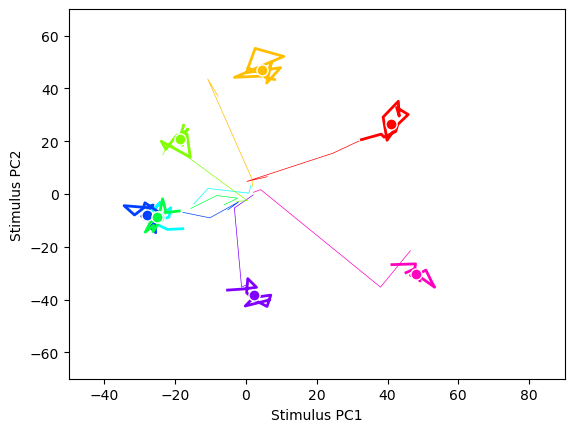

In [12]:
fig, ax = plt.subplots()
ax.set_xlim([-50, 90])
ax.set_ylim([-70, 70])

# plot the population trajectory in the coding subspace formed by the first two principal axes
i_pre_delay = timebins.fixation | timebins.cue
for i in range(n_cues):
    ax.plot(PC_time[i, 0, i_pre_delay], PC_time[i, 1, i_pre_delay], '-', color=cue_colors[i, :], linewidth=0.5)
    ax.plot(PC_time[i, 0, timebins.delay], PC_time[i, 1, timebins.delay], '-', color=cue_colors[i, :], linewidth=2)

# plot the average population activity for each cue
for i in range(n_cues):
    ax.plot(PC_avg[i, 0], PC_avg[i, 1], 'o', color='w', markerfacecolor=cue_colors[i, :], linewidth=2, markersize=8)

# add axis labels
ax.set_xlabel('Stimulus PC1')
ax.set_ylabel('Stimulus PC2')

# show the plot
plt.show()